In [1]:
import argparse
import csv
import numpy as np
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import recurrent
from keras.models import Graph, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import cPickle as pickle
import theano.tensor as T
from theano import function

Using Theano backend.


In [2]:
def mean(x, axis=None, keepdims=False):
    return T.mean(x, axis=axis, keepdims=keepdims)

def l2_normalize(x, axis):
    norm = T.sqrt(T.sum(T.square(x), axis=axis, keepdims=True))
    return x / norm

def cosine_similarity(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_pred.ndim == 2
    y_true = l2_normalize(y_true, axis=1)
    y_pred = l2_normalize(y_pred, axis=1)
    return T.sum(y_true * y_pred, axis=1, keepdims=False)

def cosine_ranking_loss(y_true, y_pred):
    q = y_pred[0::3]
    a_correct = y_pred[1::3]
    a_incorrect = y_pred[2::3]

    return mean(T.maximum(0., args.margin - cosine_similarity(q, a_correct) + cosine_similarity(q, a_incorrect)) - y_true[0]*0, axis=-1)

In [3]:
def np_l2_normalize(x, axis):
    norm = np.sqrt(np.sum(np.square(x), axis=axis, keepdims=True))
    return x / norm

def np_cosine_similarity(y_true, y_pred):
    assert y_true.ndim == 2
    assert y_pred.ndim == 2
    y_true = np_l2_normalize(y_true, axis=1)
    y_pred = np_l2_normalize(y_pred, axis=1)
    return np.sum(y_true * y_pred, axis=1, keepdims=False)

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("model_path")
parser.add_argument("csv_file")
parser.add_argument("--write_predictions", default="predictions.csv")
parser.add_argument("--tokenizer", default="model/tokenizer.pkl")
parser.add_argument("--rnn", choices=["LSTM", "GRU"], default="GRU")
parser.add_argument("--embed_size", type=int, default=300)
parser.add_argument("--hidden_size", type=int, default=1024)
parser.add_argument("--layers", type=int, default=1)
parser.add_argument("--dropout", type=float, default=0)
parser.add_argument("--bidirectional", action='store_true', default=False)
parser.add_argument("--batch_size", type=int, default=300)
parser.add_argument("--maxlen", type=int)
parser.add_argument("--vocab_size", type=int)
parser.add_argument("--optimizer", choices=['adam', 'rmsprop'], default='adam')
parser.add_argument("--verbose", type=int, choices=[0, 1, 2], default=1)
parser.add_argument("--margin", type=float, default=0.01)
args = parser.parse_args("model/simple_1400000.pkl data/training_set.tsv --vocab_size 107149".split())

In [99]:
print "Loading data..."
ids = []
questions = []
corrects = []
answersA = []
answersB = []
answersC = []
answersD = []
with open(args.csv_file) as f:
  reader = csv.reader(f, delimiter="\t", strict=True, quoting=csv.QUOTE_NONE)
  line = next(reader)  # ignore header
  is_train_set = (len(line) == 7)
  for line in reader:
    ids.append(line[0])
    questions.append(line[1])
    if is_train_set:
      corrects.append(line[2])
      answersA.append(line[3])
      answersB.append(line[4])
      answersC.append(line[5])
      answersD.append(line[6])
    else:
      answersA.append(line[2])
      answersB.append(line[3])
      answersC.append(line[4])
      answersD.append(line[5])
print "Questions: ", len(questions)
assert len(questions) == len(answersA) == len(answersB) == len(answersC) == len(answersD)
assert not is_train_set or len(corrects) == len(questions)

Loading data...
Questions:  2500


In [100]:
print "Sample question and answers:"
for i in xrange(3):
  print questions[i], "A:", answersA[i], "B:", answersB[i], "C:", answersC[i], "D:", answersD[i], "Correct: ", corrects[i] if is_train_set else '?'

Sample question and answers:
When athletes begin to exercise, their heart rates and respiration rates increase.  At what level of organization does the human body coordinate these functions? A: at the tissue level B: at the organ level C: at the system level D: at the cellular level Correct:  C
Which example describes a learned behavior in a dog? A: smelling the air for odors B: barking when disturbed C: sitting on command D: digging in soil Correct:  C
When two nuclei are combined into one nucleus, there is a slight change in mass and the release of a large amount of energy. What is this process called? A: conversion B: reaction C: fission D: fusion Correct:  D


In [101]:
texts = questions + answersA + answersB + answersC + answersD
print "Texts size:", len(texts)

Texts size: 12500


In [8]:
tokenizer = pickle.load(open(args.tokenizer, "rb"))
sequences = tokenizer.texts_to_sequences(texts)

In [9]:
if args.maxlen:
  maxlen = args.maxlen
else:
  maxlen = max([len(s) for s in sequences])
print "Sequences maxlen:", maxlen

Sequences maxlen: 179


In [10]:
texts = pad_sequences(sequences, maxlen=maxlen) 

In [11]:
vocab_size = np.max(texts) + 1
if args.vocab_size:
  print "Overriding original vocabulary size", vocab_size
  vocab_size = args.vocab_size
print "Vocabulary size:", vocab_size, "Texts: ", texts.shape

Overriding original vocabulary size 107125
Vocabulary size: 107149 Texts:  (12500L, 179L)


In [12]:
if args.rnn == 'GRU':
  RNN = recurrent.GRU
elif args.rnn == 'LSTM':
  RNN = recurrent.LSTM
else:
  assert False, "Invalid RNN"

In [13]:
print "Creating model..."

if args.bidirectional:
  model = Graph()
  model.add_input(name="input", batch_input_shape=(args.batch_size,)+texts.shape[1:], dtype="uint")
  model.add_node(Embedding(vocab_size, args.embed_size, mask_zero=True), name="embed", input='input')
  for i in xrange(args.layers):
    model.add_node(RNN(args.hidden_size, return_sequences=False if i + 1 == args.layers else True), 
        name='forward'+str(i+1), 
        input='embed' if i == 0 else 'dropout'+str(i) if args.dropout > 0 else None, 
        inputs=['forward'+str(i), 'backward'+str(i)] if i > 0 and args.dropout == 0 else [])
    model.add_node(RNN(args.hidden_size, return_sequences=False if i + 1 == args.layers else True, go_backwards=True), 
        name='backward'+str(i+1), 
        input='embed' if i == 0 else 'dropout'+str(i) if args.dropout > 0 else None, 
        inputs=['forward'+str(i), 'backward'+str(i)] if i > 0 and args.dropout == 0 else [])
    if args.dropout > 0:
      model.add_node(Dropout(args.dropout), name='dropout'+str(i+1), inputs=['forward'+str(i+1), 'backward'+str(i+1)])
  model.add_output(name='output',
      input='dropout'+str(args.layers) if args.dropout > 0 else None,
      inputs=['forward'+str(args.layers), 'backward'+str(args.layers)] if args.dropout == 0 else [])
else:
  model = Sequential()
  model.add(Embedding(vocab_size, args.embed_size, mask_zero=True))
  for i in xrange(args.layers):
    model.add(RNN(args.hidden_size, return_sequences=False if i + 1 == args.layers else True))
    if args.dropout > 0:
      model.add(Dropout(args.dropout))

model.summary()

Creating model...
--------------------------------------------------------------------------------
Initial input shape: (None, 107149)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Embedding (embedding)         (None, None, 300)             32144700            
GRU (gru)                     (None, 1024)                  4070400             
--------------------------------------------------------------------------------
Total params: 36215100
--------------------------------------------------------------------------------


In [14]:
print "Loading weights from %s" % args.model_path
model.load_weights(args.model_path)

Loading weights from model/simple_1400000.pkl


In [15]:
print "Compiling model..."
if args.bidirectional:
  model.compile(optimizer=args.optimizer, loss={'output': cosine_ranking_loss})
else:
  model.compile(optimizer=args.optimizer, loss=cosine_ranking_loss)

Compiling model...


In [16]:
if args.bidirectional:
  pred = model.predict({'input': texts}, batch_size=args.batch_size, verbose=args.verbose)
else:
  pred = model.predict(texts, batch_size=args.batch_size, verbose=args.verbose)

print "Predictions: ", pred.shape

12500/12500 [==============================] - 451s   
Predictions:  (12500L, 1024L)


In [17]:
print pred[0,:10]
print pred[1,:10]
print pred[2,:10]
print pred[3,:10]
print pred[4,:10]

[  1.25983125e-02   9.99998808e-01   7.18230614e-04   9.99998868e-01
   9.99973357e-01   9.54917446e-03   6.92471769e-03   5.97138554e-02
   9.53765392e-01   9.71550763e-01]
[  1.03059493e-03   9.99998808e-01   1.34690036e-03   7.03499303e-04
   9.98515368e-01   3.50946165e-03   2.06653983e-03   4.07463413e-05
   1.53134548e-04   1.77163452e-01]
[  7.73918699e-04   9.99998808e-01   2.68035015e-04   1.00000000e+00
   9.99997973e-01   3.82178137e-03   7.41664902e-04   9.82717395e-01
   4.83897150e-01   4.94619459e-02]
[  7.77361565e-04   9.99998808e-01   2.30792654e-03   2.35250673e-06
   9.99507427e-01   3.41041744e-01   7.54318724e-04   5.92469990e-01
   1.68930390e-04   9.72303212e-01]
[ 0.01265316  0.99999881  0.0024676   1.          0.99997342  0.00508639
  0.01209638  0.65023273  0.957681    0.85449433]


In [34]:
print pred[0,:10]
print pred[1,:10]
print pred[2,:10]
print pred[3,:10]
print pred[4,:10]

[ 0.02085971  0.99999648  0.0018542   0.99999774  0.99995291  0.01875974
  0.01836238  0.51649433  0.96257246  0.90369856]
[  4.17653844e-03   9.99996483e-01   3.21462331e-03   9.75679141e-03
   9.98000801e-01   1.84440345e-03   6.84324466e-03   5.95173216e-04
   7.39222101e-04   4.13780659e-02]
[  1.53913419e-03   9.99996483e-01   4.96424444e-04   1.00000000e+00
   9.99995112e-01   1.83061324e-03   2.02695816e-03   8.48859310e-01
   8.05777431e-01   4.77028377e-02]
[  3.84272565e-03   9.99996483e-01   6.17112964e-03   2.98524719e-05
   9.97837484e-01   6.67806506e-01   4.21950733e-03   7.08017349e-01
   5.39337634e-04   7.43280768e-01]
[ 0.01425678  0.99999648  0.00445294  0.99999464  0.99973041  0.00856616
  0.01294734  0.63259465  0.33864403  0.50366729]


In [79]:
pred.shape

(12500L, 1024L)

In [80]:
questions = pred[0:2500]
answersA = pred[2500:5000]
answersB = pred[5000:7500]
answersC = pred[7500:10000]
answersD = pred[10000:12500]
print questions.shape, answersA.shape, answersB.shape, answersC.shape, answersD.shape

(2500L, 1024L) (2500L, 1024L) (2500L, 1024L) (2500L, 1024L) (2500L, 1024L)


In [81]:
sims = np.array([
  np_cosine_similarity(questions, answersA),
  np_cosine_similarity(questions, answersB),
  np_cosine_similarity(questions, answersC),
  np_cosine_similarity(questions, answersD)
])
print sims.shape

(4L, 2500L)


In [82]:
preds = np.argmax(sims, axis=0)
print preds.shape

(2500L,)


In [83]:
print sims[0][2]
print sims[1][2]
print sims[2][2]
print sims[3][2]

0.949727274387
0.947104976327
0.940973584745
0.955797546937


In [84]:
preds = [chr(ord('A') + p) for p in preds]
preds[:10]

['C', 'D', 'D', 'C', 'B', 'B', 'C', 'A', 'B', 'B']

In [85]:
if is_train_set:
  correct = sum([corrects[i] == p for i,p in enumerate(preds)])
  print correct
  print "Accuracy: %f" % (float(correct) / len(preds))

851
Accuracy: 0.340400


In [25]:
answersA[0]

array([  1.03059493e-03,   9.99998808e-01,   1.34690036e-03, ...,
         7.79462255e-08,   6.45794496e-02,   2.28285063e-02])

In [86]:
q = 'When two nuclei are combined into one nucleus, there is a slight change in mass and the release of a large amount of energy. What is this process called?'
a1 = 'conversion'
a2 = 'reaction'
a3 = 'fission'
a4 = 'fusion'
q = 'Which example describes a learned behavior in a dog?'
a1 = 'smelling the air for odors'
a2 = 'barking when disturbed'
a3 = 'sitting on command'
a4 = 'digging in soil'
seqs = tokenizer.texts_to_sequences([q, a1, a2, a3, a4])
txts = pad_sequences(seqs, maxlen=maxlen) 
preds = model.predict(txts, batch_size=args.batch_size, verbose=args.verbose)

5/5 [==============================] - 0s


In [87]:
preds[0]

array([  1.03059493e-03,   9.99998808e-01,   1.34690036e-03, ...,
         7.79462255e-08,   6.45794496e-02,   2.28285063e-02])

In [88]:
preds[1]

array([ 0.00660113,  0.99999881,  0.00129026, ...,  0.0010187 ,
        0.89092034,  0.79156929])

In [89]:
preds[2]

array([ 0.0023178 ,  0.99999881,  0.00138227, ...,  0.01258495,
        0.00688165,  0.51416862])

In [90]:
preds[3]

array([  5.69969928e-03,   9.99998808e-01,   2.89638154e-03, ...,
         1.37676216e-05,   8.58215928e-01,   1.82302684e-01])

In [91]:
preds[4]

array([  4.87987790e-03,   9.99998808e-01,   6.11805473e-04, ...,
         6.01614534e-04,   9.95291948e-01,   9.32219923e-01])

In [92]:
np_cosine_similarity(np.vstack((preds[0], preds[0], preds[0], preds[0])), preds[1:])

array([ 0.8946196 ,  0.88960262,  0.90086085,  0.91139875])

In [93]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#model_dr = TSNE(n_components=2, random_state=0)
model_dr = PCA(n_components=2)

X_dr = model_dr.fit_transform(pred)

In [94]:
model_dr.explained_variance_ratio_

array([ 0.10496895,  0.09455091])

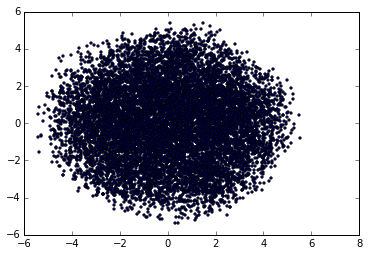

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_dr[:, 0], X_dr[:, 1], marker=".")

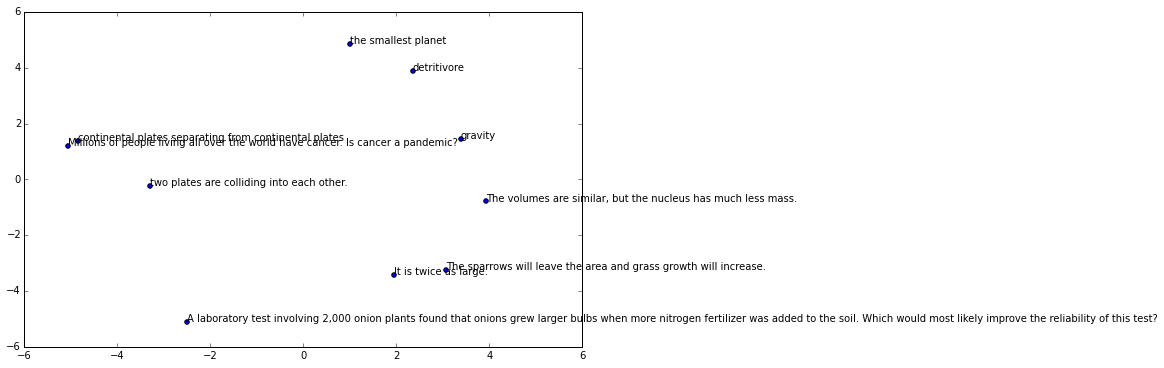

In [123]:
NUM_SAMPLE = 10
idx = np.random.choice(range(pred.shape[0]), NUM_SAMPLE, replace=False)
pred_sub = pred[idx]
text_sub = [texts[i] for i in idx]

model_dr = PCA(n_components=2)
X_dr = model_dr.fit_transform(pred_sub)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X_dr[:, 0], X_dr[:, 1])

for i in xrange(NUM_SAMPLE):
    ax.annotate(text_sub[i], (X_dr[i, 0], X_dr[i, 1]))

In [114]:
list(idx)[[2.3]]

TypeError: list indices must be integers, not list

In [110]:
preds

array([[  1.03059493e-03,   9.99998808e-01,   1.34690036e-03, ...,
          7.79462255e-08,   6.45794496e-02,   2.28285063e-02],
       [  6.60112500e-03,   9.99998808e-01,   1.29026314e-03, ...,
          1.01869891e-03,   8.90920341e-01,   7.91569293e-01],
       [  2.31779739e-03,   9.99998808e-01,   1.38226605e-03, ...,
          1.25849489e-02,   6.88164914e-03,   5.14168620e-01],
       [  5.69969928e-03,   9.99998808e-01,   2.89638154e-03, ...,
          1.37676216e-05,   8.58215928e-01,   1.82302684e-01],
       [  4.87987790e-03,   9.99998808e-01,   6.11805473e-04, ...,
          6.01614534e-04,   9.95291948e-01,   9.32219923e-01]])

In [132]:
data = ['How are you?', 'How are you today']

print "Tokenizing data..."
tokenizer = Tokenizer(nb_words=3)
tokenizer.fit_on_texts(data)

print "Converting text to sequences..."
data_seq = tokenizer.texts_to_sequences(data)

Tokenizing data...
Converting text to sequences...


In [133]:
data_seq

[[1, 2], [1, 2]]

In [ ]:
data_maxlen = max([len(q) for q in data_seq])
print "Questions maxlen:", data_maxlen

print "Padding sequences..."
data_seq_pad = pad_sequences(data_seq, maxlen=data_maxlen) 

print "Sample padded sequences:"
for i in xrange(3):
    print data_seq_pad[i]